# Import Libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy.ndimage import gaussian_filter1d
from IPython.display import Audio
from numpy.fft import fft, ifft
import pickle

import io
from reportlab.pdfgen import canvas
from reportlab.lib.units import mm
from reportlab.lib import pagesizes
A6_LS = pagesizes.landscape(pagesizes.A6)
PAGE_SMALL = (160*mm, 80*mm)

# import os
# import sys
# print(os.getcwd())
# sys.path.append(os.getcwd())
import plotting_util

import configuration as cfg

%matplotlib inline

# Read audio input

Using scipy.io.wavefile to read the wave file. Each of the two stereo channels is stored into a seperate list.

In [8]:
samplerate, data = read(f'{cfg.input_path}{cfg.input_filename}.wav')

plotting_util.create_pdf_text_page("summarized_plots/pdf/(#0_preamble)file_info", f"filename: \'{cfg.input_path}{cfg.input_filename}.wav\'", page_size=PAGE_SMALL)

# data_lt = data[:, 0] # left channel
# data_rt = data[:, 1] # right channel

C:\Users\Levin\AppData\Local\Temp\ipykernel_25764\938411214.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = read(f'{cfg.input_path}{cfg.input_filename}.wav')


# Remove signs from raw data

In [9]:
data = np.abs(data)

# normalize array to range [0; 1]
data = data / np.max(data, axis=0) # directly dividing array: %timeit: it's faster than "data * (1/max(...))

# Plot waveform

Using matplotlib.pyplot, the signal is plotted.

Using the line magic function ```%matplotlib inline```, the plot is output directly below the next Jupyter cell.

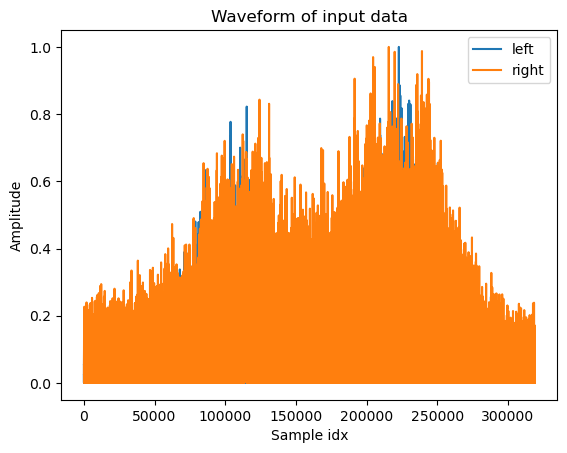

In [10]:
plt.figure()
plt.plot(data)
plt.xlabel("Sample idx")
plt.ylabel("Amplitude")
plt.title("Waveform of input data")
plt.legend(["left", "right"])

plt.savefig("summarized_plots/png/(a_0)waveform.png")
plt.savefig("summarized_plots/pdf/(a_0)waveform.pdf")
plt.show()


# Average input data

Calculates the average amplitude for every ```1 / res``` seconds.
(e.g. set ```res = 2``` to generate two average points per second)

*Note: During averaging, both channels are combined into one main average channel*

In [11]:
step_increase: int = (int) (samplerate / cfg.averaging_resolution)

output_debug_list = []

avg_data = []
for samples in range(0, len(data), step_increase):
    tmp = np.average(data[samples : (samples + step_increase)])
    
    avg_data.append(np.average(data[samples: samples + step_increase]))

    # generate debug output
    inner_debug_list = []
    inner_debug_list.append(samples / samplerate)
    inner_debug_list.append((samples + step_increase) / samplerate)
    inner_debug_list.append(tmp)
    output_debug_list.append(inner_debug_list)


In [12]:
df = pd.DataFrame(output_debug_list, columns=['Von', 'Bis', 'Amp'])
df.style.background_gradient(axis=0, subset=['Amp'])

# keep remainder of cell empty to display table with gradient

df.to_csv(f'{cfg.input_path}csv/{cfg.input_filename}.csv', index=True, sep=';', encoding='utf8')


# Calculate rate of change

Equivalent to calculating the slope of a curve.

Here, the slope is calculated using the np.gradient(list) function.

<Figure size 640x480 with 0 Axes>

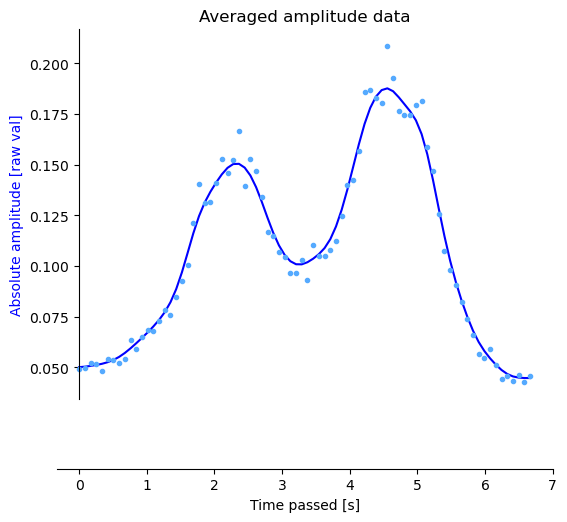

In [13]:
avg_smoothed = gaussian_filter1d(avg_data, sigma=2)

gradients = np.gradient(avg_data)
gradients_smoothed = gaussian_filter1d(gradients, sigma=2) #! Caution: may heavily alter the values


# plot_amplitude_data("Averaged amplitude data", "Absolute amplitude [raw val]", avg_smoothed, avg_data, "Rate of change of amplitude", gradients_smoothed, gradients)
plotting_util.plot_amplitude_data("Averaged amplitude data", "Absolute amplitude [raw val]", cfg.averaging_resolution, avg_smoothed, avg_data)

# Make symmetrical

Find the highest point of the curve, then average the points to the left with the points to the right.

(array([54], dtype=int64),)


<Figure size 640x480 with 0 Axes>

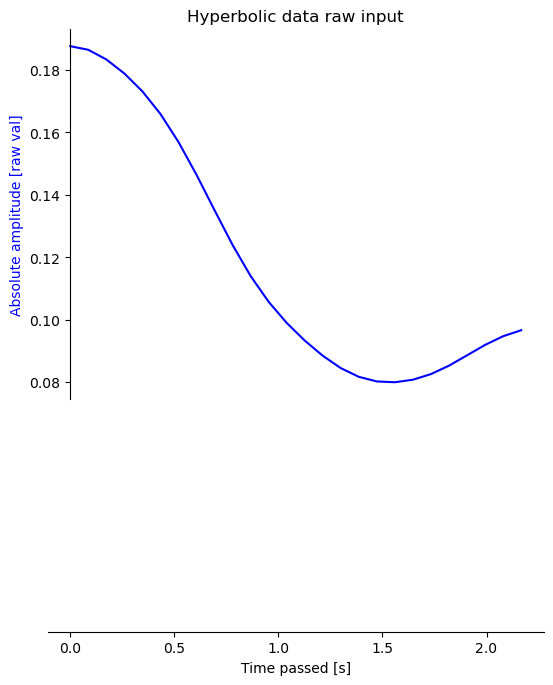

In [14]:
max_val = np.amax(avg_smoothed)
max_idx = np.where(avg_smoothed == max_val) # returns list
print(max_idx)
max_idx = int(np.average(max_idx)) # center of maxima

# find closer border
size_left_side = max_idx # number of elements to the left
size_right_side = len(avg_smoothed) - max_idx # number of elements to the right
size_smaller = min(size_left_side, size_right_side)
symm_array_len = size_smaller # new number of total elements

symm_array = [0] * symm_array_len
for i_symm in range(max_idx, max_idx + size_smaller):
    symm_array[i_symm - max_idx] = (avg_smoothed[i_symm] + avg_smoothed[2 * max_idx - i_symm]) / 2

# Export serialized symmetrical list to file
def export_list_binary(filename:str, list_to_save:list):
    with open(filename + '.dat', 'wb') as fd:
        pickle.dump(list_to_save, fd)

export_list_binary("hyperbolic_raw_data", symm_array)

plotting_util.plot_amplitude_data("Hyperbolic data raw input", "Absolute amplitude [raw val]", cfg.averaging_resolution, symm_array)

compute_info_str = f"""
resolution: 1 / {cfg.averaging_resolution} [seconds]
Uebergabewerte: len(symm_avg_points) = {len(symm_array)}
"""
plotting_util.create_pdf_text_page(
    "summarized_plots/pdf/(a_x)compute_info", compute_info_str, page_size=PAGE_SMALL)


# Weitere Notizen

dB Umrechnung: https://www.dsprelated.com/showthread/comp.dsp/29246-1.php

Inverse Square Law: https://web.archive.org/web/20210124224420/https://uc.yamaha.com/insights/blog/2020/march/inverse-square-law-what-is-it/

Relation Intensity ~ Amplitude: https://physics.stackexchange.com/questions/322498/what-is-the-relationship-between-amplitude-and-the-distance-from-the-source-of-a

https://www.quora.com/How-does-amplitude-change-with-distance-1



Rekursive Annäherung:

Funktion x-Verschiebung berechnen, dann r/x -> r brute force mäßig ermitteln

Gütefunktion: Abstand der Messpunkte zur Funktion entlang der y-Achse; Betrag oder Quadrierung, da Funktion über oder unter Punkt liegen kann

\\-> Ausprobieren, ob Betrag oder Quadrat besser; wahrscheinlich Quadrat besser, da größere Abweichungen stärker gewichtet werden